In [2]:
# 预处理 解压数据集
# !unzip first_train_data.zip
# !unzip first_test_data.zip
import tensorflow as tf
# print('GPU', tf.test.is_gpu_available())

In [3]:
# 读数据
import pandas as pd
import os
import numpy

def read_data(dir):
    # 读文件名
    txt_list = []
    for filename in os.listdir(dir):
        txt_list.append(filename)
        
    df = pd.read_csv('%s/%s'%(dir, txt_list[0]), sep=',', header=None)

    i = 1

    for filename in txt_list[1:]: 
        single_df = pd.read_csv(r'%s/%s'%(dir, filename), sep=',',header=None)
        df = pd.concat([df, single_df])
        i += 1
        if(i%100 == 0):
            print(i, end=' / ')
    return df

# read_data to_csv

dataset = pd.read_csv('first_train_data.csv')
print(dataset.shape)

(10000, 2600)


In [4]:
# index文件处理
'''
import pandas as pd
import os

dir = r'./first_train_data'
index = []
label = []
label_file = pd.read_csv(r"./first_train_index_20180131.csv")
for filename in os.listdir(dir):
    temp = int(filename[:-4])
    index.append(temp)
    label.append(label_file[label_file['id']==temp]['type'].values[0])

label_pd = pd.DataFrame(label, index = index)
label_pd.to_csv(r'./first_train_index.csv')
'''
import numpy as np

ori_index = pd.read_csv('first_train_index.csv')
temp_index = ori_index['0'].values
temp_index[temp_index == 'star'] = 0.
temp_index[temp_index == 'galaxy'] = 1.
temp_index[temp_index == 'qso'] = 2.
temp_index[temp_index == 'unknown'] = 3.
print(temp_index[temp_index == 0.].size, temp_index[temp_index == 1.].size, temp_index[temp_index == 2.].size, temp_index[temp_index == 3.].size)

temp_index = np.array([temp_index]).T

9208 102 22 668


In [5]:
# 归一化处理

import numpy as np

def norm(x):
    ans = np.sqrt(np.power(x, 2).sum(axis=1))
    ans = x / ans.reshape(-1, 1)
    return ans

norm_data = norm(dataset.values)

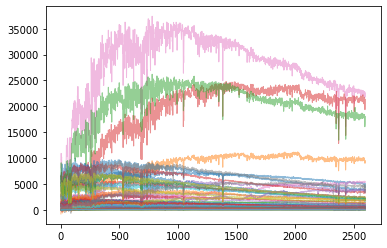

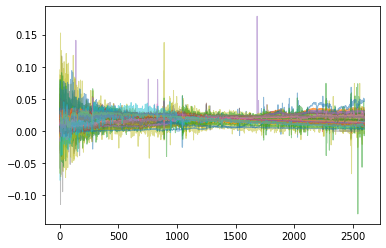

In [6]:
# 归一化后前100项比较
import matplotlib.pyplot as plt
%matplotlib inline
xx = list(range(0,2600))
plt.figure()
for i in range(100):
    plt.plot(xx, dataset.values[i], alpha=0.5, linewidth=1)
plt.show()

plt.figure()
for i in range(100):
    plt.plot(xx, norm_data[i], alpha=0.5, linewidth=1)
plt.show()

In [17]:
# 合并特征值与训练集

final_ds = np.concatenate([norm_data, temp_index], axis=1)
final_ds = final_ds.astype(np.float64)

print(final_ds.dtype)

float64


In [105]:
# 数据增强

temp_pd = pd.DataFrame(final_ds)

without_3 = temp_pd[temp_pd[2600]!=3]

add_1 = temp_pd[temp_pd[2600]==1]
add_2 = temp_pd[temp_pd[2600]==2]

for i in range(9000//102):
    without_3 = pd.concat([without_3, add_1])
    
for i in range(9000//22):
    without_3 = pd.concat([without_3, add_2])
    
print(without_3)

          0         1         2         3         4         5         6     \
0    -0.034272 -0.019884  0.011000 -0.010090 -0.015843 -0.016358 -0.019192   
1     0.001748  0.002151  0.002334  0.002115  0.001899  0.002056  0.001863   
2     0.011166  0.018280  0.022403  0.025328  0.025777  0.031962  0.030758   
3     0.026749  0.045334  0.032516  0.022937 -0.009093  0.008507  0.012309   
4     0.002097  0.002802  0.004317  0.003820  0.002738  0.003471  0.003084   
...        ...       ...       ...       ...       ...       ...       ...   
7660  0.079857 -0.021457  0.030742  0.005065  0.090616  0.003212  0.044942   
8361  0.035884  0.050055  0.046703  0.038498  0.043433  0.038838  0.043471   
9328  0.023558  0.039897  0.051797  0.048813  0.019699  0.072085  0.064217   
9347  0.001984  0.032932  0.100282  0.048434  0.028524 -0.005733 -0.032541   
9686  0.023536  0.047090  0.027570  0.028681  0.022177  0.002056  0.013161   

          7         8         9     ...      2591      2592    

In [107]:
new_final_ds=without_3.sample(frac=1).values

In [110]:
import tensorflow as tf
from tensorflow.keras import Model

class MyCNN(Model):
    def __init__(self):
        # 第一层卷积层
        super(MyCNN,self).__init__()
        self.c1 = tf.keras.layers.Conv1D(filters=64, kernel_size=10, padding='same')
        self.b1 = tf.keras.layers.BatchNormalization()
        self.a1 = tf.keras.layers.Activation('relu')
        
        # 第二层卷积层
        self.c2 = tf.keras.layers.Conv1D(filters=128, kernel_size=20, padding='same')
        self.b2 = tf.keras.layers.BatchNormalization()
        self.a2 = tf.keras.layers.Activation('relu')
        self.p1 = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')
        self.d1 = tf.keras.layers.Dropout(0.2)
        
        # 第三层卷积层
        self.c3 = tf.keras.layers.Conv1D(filters=128, kernel_size=20, padding='same')
        self.b3 = tf.keras.layers.BatchNormalization()
        self.a3 = tf.keras.layers.Activation('relu')
        
        # 第四层卷积层
        self.c4 = tf.keras.layers.Conv1D(filters=64, kernel_size=10, padding='same')
        self.b4 = tf.keras.layers.BatchNormalization()
        self.a4 = tf.keras.layers.Activation('relu')
        self.p2 = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')
        self.d2 = tf.keras.layers.Dropout(0.2)
        
        # 全连接层
        self.flatten = tf.keras.layers.Flatten()
        
        self.f1 = tf.keras.layers.Dense(256,activation='relu') #
        self.d3 = tf.keras.layers.Dropout(0.2)
        
        self.f2 = tf.keras.layers.Dense(128,activation='relu') #
        self.d4 = tf.keras.layers.Dropout(0.2)
        
        self.f3 = tf.keras.layers.Dense(3,activation='softmax')

    def call(self,x):
        # 搭建网络结构，进行一次前向传播，返回y
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        x = self.p1(x)
        x = self.d1(x)
        
        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        
        x = self.c4(x)
        x = self.b4(x)
        x = self.a4(x)
        x = self.p2(x)
        x = self.d2(x)
        
        x = self.flatten(x)
        x = self.f1(x)
        x = self.d3(x)
        x = self.f2(x)
        x = self.d4(x)
        y = self.f3(x)
        return y

In [111]:
# x_train = final_ds[0:2000,0:-1]
# y_train = final_ds[0:2000,-1]

# x_test = final_ds[2000:4000,0:-1]
# y_test = final_ds[2000:4000,-1]

# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# y_train = y_train.reshape(y_train.shape[0], 1)
# y_test = y_test.reshape(y_test.shape[0], 1)

X = new_final_ds[:,0:-1]
y = new_final_ds[:,-1]

X = X.reshape(X.shape[0], X.shape[1], 1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape,x_train, y_train, x_test, y_test)

(21844, 2600, 1) (21844,) (5462, 2600, 1) (5462,) [[[0.00603576]
  [0.00334541]
  [0.00973313]
  ...
  [0.0124523 ]
  [0.0143405 ]
  [0.0160396 ]]

 [[0.04054747]
  [0.0270181 ]
  [0.00547321]
  ...
  [0.01066047]
  [0.01146117]
  [0.01073954]]

 [[0.01671475]
  [0.01951205]
  [0.0398515 ]
  ...
  [0.01037402]
  [0.01032643]
  [0.01055237]]

 ...

 [[0.01196418]
  [0.01940079]
  [0.00772099]
  ...
  [0.01955687]
  [0.018123  ]
  [0.01968228]]

 [[0.01638393]
  [0.0194966 ]
  [0.02220219]
  ...
  [0.00961425]
  [0.01032723]
  [0.01047641]]

 [[0.00659693]
  [0.00998401]
  [0.00847945]
  ...
  [0.01797781]
  [0.02063591]
  [0.01959749]]] [0. 2. 0. ... 1. 0. 1.] [[[-0.00012615]
  [-0.01006608]
  [-0.01007657]
  ...
  [ 0.01574938]
  [ 0.01898867]
  [ 0.02184799]]

 [[ 0.01207269]
  [-0.00851652]
  [ 0.01053929]
  ...
  [ 0.01348813]
  [ 0.01544525]
  [ 0.01832088]]

 [[ 0.01206924]
  [ 0.00439508]
  [ 0.00471154]
  ...
  [ 0.01596784]
  [ 0.01713224]
  [ 0.01933891]]

 ...

 [[-0.00157151

In [112]:
def get_pred(y):
    ans = []
    for i in y:
        max_no = 0
        max = 0
        for j in range(3):
            if(i[j] > max):
                max = i[j]
                max_no = j
        ans.append(2-max_no)
    return np.array(ans)

KFold  1 :
Train on 21844 samples, validate on 5462 samples
Epoch 1/15
21844/21844 [==============================] - 34s 2ms/sample - loss: 1.7512 - sparse_categorical_accuracy: 0.8125 - val_loss: 3.4335 - val_sparse_categorical_accuracy: 0.3312
Epoch 2/15
21844/21844 [==============================] - 30s 1ms/sample - loss: 0.1184 - sparse_categorical_accuracy: 0.9670 - val_loss: 7.8092 - val_sparse_categorical_accuracy: 0.3312
Epoch 3/15
21844/21844 [==============================] - 30s 1ms/sample - loss: 0.0458 - sparse_categorical_accuracy: 0.9895 - val_loss: 7.7469 - val_sparse_categorical_accuracy: 0.3312
Epoch 4/15
21844/21844 [==============================] - 30s 1ms/sample - loss: 0.0281 - sparse_categorical_accuracy: 0.9930 - val_loss: 6.9260 - val_sparse_categorical_accuracy: 0.3312
Epoch 5/15
21844/21844 [==============================] - 30s 1ms/sample - loss: 0.0205 - sparse_categorical_accuracy: 0.9956 - val_loss: 6.2364 - val_sparse_categorical_accuracy: 0.3312
Epoch

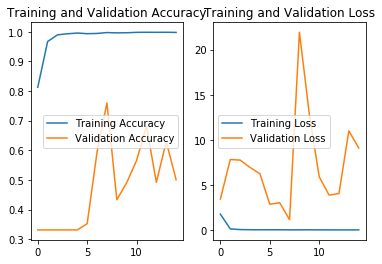

KFold  2 :
Train on 21845 samples, validate on 5461 samples
Epoch 1/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0046 - sparse_categorical_accuracy: 0.9989 - val_loss: 2.3548 - val_sparse_categorical_accuracy: 0.7316
Epoch 2/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0081 - sparse_categorical_accuracy: 0.9981 - val_loss: 16.4502 - val_sparse_categorical_accuracy: 0.5074
Epoch 3/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0052 - sparse_categorical_accuracy: 0.9988 - val_loss: 12.2857 - val_sparse_categorical_accuracy: 0.7129
Epoch 4/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0030 - sparse_categorical_accuracy: 0.9993 - val_loss: 38.6021 - val_sparse_categorical_accuracy: 0.4096
Epoch 5/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0023 - sparse_categorical_accuracy: 0.9996 - val_loss: 52.5202 - val_sparse_categorical_accuracy: 0.3911
E

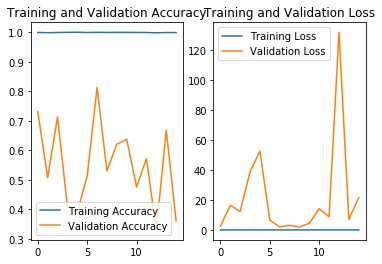

KFold  3 :
Train on 21845 samples, validate on 5461 samples
Epoch 1/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0096 - sparse_categorical_accuracy: 0.9984 - val_loss: 20.3331 - val_sparse_categorical_accuracy: 0.4658
Epoch 2/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0013 - sparse_categorical_accuracy: 0.9998 - val_loss: 3.3196 - val_sparse_categorical_accuracy: 0.7270
Epoch 3/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0011 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.1446 - val_sparse_categorical_accuracy: 0.9498
Epoch 4/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0057 - sparse_categorical_accuracy: 0.9990 - val_loss: 86.3807 - val_sparse_categorical_accuracy: 0.3435
Epoch 5/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0033 - sparse_categorical_accuracy: 0.9994 - val_loss: 5.1310 - val_sparse_categorical_accuracy: 0.5889
Epo

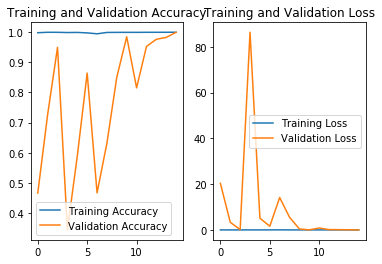

KFold  4 :
Train on 21845 samples, validate on 5461 samples
Epoch 1/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0016 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.3829 - val_sparse_categorical_accuracy: 0.8872
Epoch 2/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 9.8310e-04 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.5081 - val_sparse_categorical_accuracy: 0.8991
Epoch 3/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0024 - sparse_categorical_accuracy: 0.9995 - val_loss: 8.9479 - val_sparse_categorical_accuracy: 0.4100
Epoch 4/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0037 - sparse_categorical_accuracy: 0.9992 - val_loss: 2.5080 - val_sparse_categorical_accuracy: 0.6642
Epoch 5/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0010 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.3592 - val_sparse_categorical_accuracy: 0.8795
E

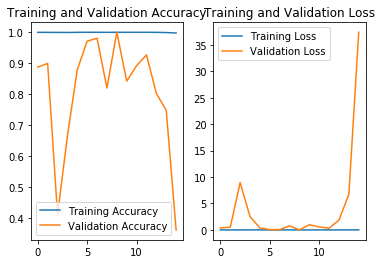

KFold  5 :
Train on 21845 samples, validate on 5461 samples
Epoch 1/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0139 - sparse_categorical_accuracy: 0.9981 - val_loss: 1.9178 - val_sparse_categorical_accuracy: 0.7383
Epoch 2/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0021 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.3921 - val_sparse_categorical_accuracy: 0.8649
Epoch 3/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0027 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0205 - val_sparse_categorical_accuracy: 0.9923
Epoch 4/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0029 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0961 - val_sparse_categorical_accuracy: 0.9670
Epoch 5/15
21845/21845 [==============================] - 30s 1ms/sample - loss: 0.0040 - sparse_categorical_accuracy: 0.9996 - val_loss: 4.5129e-05 - val_sparse_categorical_accuracy: 1.0000
E

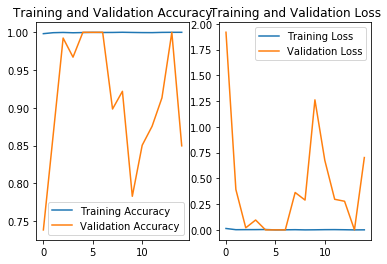

In [118]:
# K折交叉验证
from sklearn.model_selection import KFold, cross_val_score
    
model = MyCNN()
model.build(input_shape=(128, 2600, 1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])
a = 0
for train_index, test_index in KFold(n_splits=5).split(new_final_ds):
    a += 1
    print('KFold ', a, ':')

    train_ds, test_ds = new_final_ds[train_index], new_final_ds[test_index]
    
    X_train, X_test = train_ds[:,0:-1], test_ds[:,0:-1]
    y_train, y_test = train_ds[:,-1], test_ds[:,-1]

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    

    #
    
    history = model.fit(X_train, y_train, batch_size=256, epochs=15, validation_data=(X_test,y_test), validation_freq=1)
    model.summary()

    
    # 预测
    from sklearn.metrics import f1_score
    y_pred = get_pred(model.predict(X_test))
    
    print(y_pred.shape, y_pred)
    print("f1_score:", f1_score(y_test, y_pred, average='macro'))

    #print(history.history.keys())
    
    
    #显示训练集和验证集的acc和loss曲线
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.subplot(1,2,1)
    plt.plot(acc,label='Training Accuracy')
    plt.plot(val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(loss,label='Training Loss')
    plt.plot(val_loss,label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
